# **5장. 시계열 데이터와 자연어 처리**  

## **5-4절. 감성 분석 모델**  

📌 KoNLPy 라이브러리 설치 및 Okt 토크나이저 불러오기

In [ ]:
!apt-get install -y openjdk-11-jdk   # KoNLPy가 필요로 하는 Java 프로그램 설치
!pip install konlpy                  # 패키지 설치
from konlpy.tag import Okt           # 패키지 불러오기

📌[실습 05-47] 라이브러리 불러오기

In [ ]:
# 필요한 라이브러리 불러오기
!pip install koreanize_matplotlib  # 그래프용 한글 폰트
import koreanize_matplotlib

import pandas as pd; import numpy as np; import matplotlib.pyplot as plt; import random
import tensorflow as tf; from tensorflow import keras; import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.utils import to_categorical  # 원핫 변환 함수
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, Dropout, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback, EarlyStopping
from konlpy.tag import Okt
import warnings; warnings.filterwarnings('ignore')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 71.4 MB/s eta 0:00:00


📌[실습 05-48] 데이터 불러오기

본 연구(또는 교재)에서 사용한 데이터는
**Naver Sentiment Movie Corpus (NSMC)**이며,
https://github.com/e9t/nsmc

에서 제공되는 CC BY-SA 4.0 라이선스를 따릅니다.

In [ ]:
df=pd.read_csv('nsmc_converted.csv', encoding='utf-8')
df


,id,document,label
0,3764100,정말 쉽게 잊혀지지 않을 것 같은 최고의 영화~!,긍정
1,9588690,결말이 흐뭇한 이야기..,긍정
2,6155841,와~~이거 너무하자나...2시간이 아깝다.,부정
3,8484315,벗기기만 하면 다인가??3류배우들 모아 3류 에로영화 제작했구만..,부정
4,8920418,용두사미의 전형적인 예,부정
...,...,...,...
11995,9017360,그냥 누구에게나 있는 그런단점들 중독 결점 나도 가지고있는 것들,긍정
11996,10078940,코미디영화니까 이것저것 따지지말고 그냥 가볍게 보면 돼.,부정
11997,8554659,킬링타임용으로도 부족한영화..,부정
11998,9612573,읍면사람들의 소박한 이야기...그래서 평범한 영화...조금 아쉽다,부정


📌[실습 05-48] 피처와 타깃 정의하기

In [ ]:
x=df['document']                     # 피처(문장) 정의하기
y=pd.get_dummies(df['label'])        # 타깃(원핫 인코딩) 정의하기
y.head(5)


,긍정,부정
0,True,False
1,True,False
2,False,True
3,False,True
4,False,True


### 토큰화와 인코딩

📌[실습 05-50] 댓글 데이터를 형태소 단위로 토큰화하기

In [ ]:
okt=Okt()
tokenizer=okt.morphs
tokenized_x=[tokenizer(idx) for idx in x]
print(tokenized_x[0])

['정말', '쉽게', '잊혀지지', '않을', '것', '같은', '최고', '의', '영화', '~!']


📌[실습 05-51] 인코딩 딕셔너리 만들기

In [ ]:
# 토큰 --> 인덱스 사전 생성
word_to_index={}
index=1  # 0은 일반적으로 패딩 용도로 남겨둠
for sentence in tokenized_x:
    for word in sentence:
        if word not in word_to_index:
            word_to_index[word] = index
            index += 1

print(word_to_index); print()
# 인덱스 ==> 토큰 사전
index_to_word={idx: word for word, idx in word_to_index.items()}


# 각 문장을 정수 시퀀스로 변환
인코딩_댓글=[[word_to_index[word] for word in sentence] for sentence in tokenized_x]
print("인코딩 결과:", 인코딩_댓글)


{'정말': 1, '쉽게': 2, '잊혀지지': 3, '않을': 4, '것': 5, '같은': 6, '최고': 7, '의': 8, '영화': 9, '~!': 10, '결말': 11, '이': 12, '흐뭇한': 13, '이야기': 14, '..': 15, '와': 16, '~~': 17, '거': 18, '너무하자나': 19, '...': 20, '2시간': 21, '아깝다': 22, '.': 23, '벗기기만': 24, '하면': 25, '다인': 26, '가': 27, '??': 28, '3': 29, '류': 30, '배우': 31, '들': 32, '모아': 33, '에로영화': 34, '제작': 35, '했구만': 36, '용두사미': 37, '전형': 38, '적': 39, '인': 40, '예': 41, '재미있어요': 42, '꼭': 43, '보세요': 44, '갑자기': 45, '왜': 46, '막판': 47, '에': 48, '트렁크': 49, '들어가서': 50, '뻘짓': 51, '이지': 52, '-_-': 53, '지': 54, '???': 55, '너무': 56, '완벽한': 57, '표절': 58, '작품': 59, '볼': 60, '만': 61, '합니다': 62, 'ㅋ': 63, '재밌어요': 64, '유역비': 65, '이뻐서': 66, '10': 67, '점': 68, '이고': 69, '나머진': 70, '전혀': 71, '게': 72, '업음': 73, '농구': 74, '참': 75, '멋지게': 76, '한다': 77, '몰랐던': 78, '역사': 79, '사실': 80, '을': 81, '일': 82, '깨워': 83, '준': 84, ',...': 85, '안재모': 86, '연기': 87, '좋았음': 88, '^*^': 89, '조카': 90, '랑': 91, '봤': 92, '눈데잼': 93, '써요': 94, '도둑': 95, '개': 96, '쓰': 97, '렉': 98, '비교': 99, '됨': 10

📌[실습 05-52] 댓글 데이터와 인코딩 결과 비교하기  

In [ ]:
print(x[1000]) # 댓글
print(인코딩_댓글[1000])

걍 시간낭비가 취미이신분들만 보세요.
[229, 244, 245, 27, 3825, 3826, 3827, 61, 44, 23]


### 패딩 및 데이터 분할

📌[실습 05-53] 패딩 기법으로 댓글 시퀀스 길이 맞추기  

In [ ]:
# 댓글의 최대 길이 파악
max_len=30
print("토큰의 최대 수=", max_len); print()
# 패딩 처리
X_encode=pad_sequences(인코딩_댓글, maxlen=max_len, padding='pre')
print(X_encode)

토큰의 최대 수= 30

[[   0    0    0 ...    8    9   10]
 [   0    0    0 ...   13   14   15]
 [   0    0    0 ...   12   22   23]
 ...
 [   0    0    0 ...  529    9   15]
 [   0    0    0 ...   20  345 3738]
 [   0    0    0 ...    9 1074  435]]


📌[실습 05-54] 데이터 분할하기

In [ ]:
#  랜덤 시드 고정
SEED=42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# 데이터 분할
x_train, x_test, y_train, y_test, x_train_text, x_test_text = train_test_split(
    X_encode, y, x, test_size=0.2, random_state=SEED)
print("x_train.shape=", x_train.shape)
print("y_train.shape=", y_train.shape)
print("x_test.shape=", x_test.shape)
print("y_test.shape=", y_test.shape)

x_train.shape= (9600, 30)
y_train.shape= (9600, 2)
x_test.shape= (2400, 30)
y_test.shape= (2400, 2)


📌[실습 05-55] 모델을 설정하고 학습하기

In [ ]:
VOCAB_SIZE=len(word_to_index)+1
embedding_dim=10    # 감성 분석 모델에 적합한 임베딩 차원 지정하기

# 모델 설정
감성=Sequential()
감성.add(Embedding(input_dim=VOCAB_SIZE, output_dim=embedding_dim))
감성.add(Dropout(0.3))
감성.add(GRU(16))
감성.add(Dense(2, activation='softmax'))    # 원핫 인코딩된 타깃 -> 소프트맥스 출력층

# 조기 종료 조건 설정하기
early_stopping=EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True )

# 컴파일 및 학습하기
감성.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=감성.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[early_stopping])


Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.5781 - loss: 0.6629 - val_accuracy: 0.7754 - val_loss: 0.4666
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8235 - loss: 0.3922 - val_accuracy: 0.8000 - val_loss: 0.4508
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9043 - loss: 0.2329 - val_accuracy: 0.7900 - val_loss: 0.5215
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9497 - loss: 0.1368 - val_accuracy: 0.7842 - val_loss: 0.6067
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9678 - loss: 0.0913 - val_accuracy: 0.7800 - val_loss: 0.6757


📌[실습 05-56] 모델의 예측 성능 평가하기

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
확률 예측
[[0.34722698 0.65277296]
 [0.99298626 0.00701369]
 [0.0315256  0.96847445]
 ...
 [0.13860375 0.8613962 ]
 [0.8481029  0.15189704]
 [0.2136547  0.78634536]]


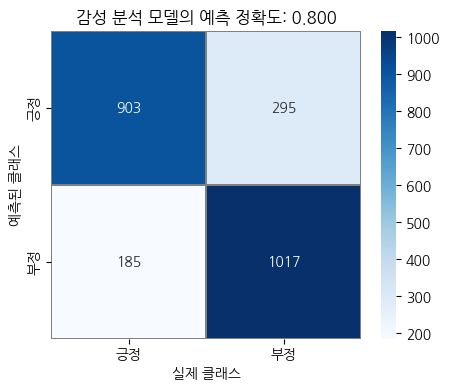

In [ ]:
클래스_라벨=["긍정", "부정"]           # 감정 클래스 이름
y_prob = 감성.predict(x_test)
print("확률 예측"); print(y_prob)
y_pred_idx=np.argmax(y_prob, axis=1)     # 예측 클래스:  0(긍정), 1(부정)
y_test_idx=np.argmax(y_test, axis=1)     # 비교를 위해, y_test도 0/1로 변환

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# 정확도 및 혼동 행렬 계산
acc=accuracy_score(y_test_idx, y_pred_idx)
cm=confusion_matrix(y_test_idx, y_pred_idx)

# 혼동 행렬 시각화
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d',linewidths=0.1, linecolor="gray",  cmap='Blues',
            xticklabels=클래스_라벨, yticklabels=클래스_라벨)
plt.title(f'감성 분석 모델의 예측 정확도: {acc:.3f}')
plt.xlabel('실제 클래스'); plt.ylabel('예측된 클래스'); plt.show()

📌[실습 05-57] 댓글의 감성 예측 결과 확인하기

In [ ]:
# 5개 샘플 무작위로 선택
sample_indices = random.sample(range(len(x_test_text)), 5)

print("감성 예측 결과 (랜덤 5개):")
for i in sample_indices:
    review = x_test_text.iloc[i]
    pred = y_pred_idx[i]
    true = y_test_idx[i]

    print(f"리뷰: {review}")
    print(f"실제: {클래스_라벨[true]}")
    print(f"예측: {클래스_라벨[pred]}")
    print("-" * 50)

감성 예측 결과 (랜덤 5개):
리뷰: 정글의 법칙 볼려다 끝난거 알고 한번 봐밨는데 재미있더라구요!!!
실제: 긍정
예측: 긍정
--------------------------------------------------
리뷰: 뭐하냐 차예련이뻐서2점준다
실제: 부정
예측: 부정
--------------------------------------------------
리뷰: 네티즌 평점 7.12 참 네티즌들이 뭘 볼줄 모른다.
실제: 긍정
예측: 부정
--------------------------------------------------
리뷰: 여주인공 얼굴에 1점을 줄수밖에 없는 이유가 고스란히 담겨있다
실제: 부정
예측: 부정
--------------------------------------------------
리뷰: 미치겟다 이게 무슨 10점 1점도 아깝더
실제: 부정
예측: 부정
--------------------------------------------------


일부 오류가 발생할 수 있는데, 그 원인은 다음 4가지를 들 수 있습니다.
* 학습 데이터가 부족하거나 댓글의 내용 자체가 모호한 경우
* 실제 댓글과 별점 평가가 불일치하는 경우
*	모델의 학습 부족 또는 하이퍼 파라미터 설정이 잘못된 경우
*	토큰화 성능의 한계

예측 성능을 높이려면 더 많은 데이터가 필요하고 정교한 전처리, 모델 튜닝 등의 추가 작업을 해야 합니다.

도전해봅시다.